# Sentiment Analysis

In this notebook, we perform sentiment analysis using the Natural Language Toolkit Sentiment Analysis pretrained model Vader Lexicon.

We will apply the model to our tweets and then compute for each user the total sentiment for the Democrat party. In case it is positive we will assign a vote to the Democrat party and we will add a vote to the Republican party otherwise.

## Imports and Reading data

In [1]:
import pandas as pd
from nltk import classify
from nltk import NaiveBayesClassifier
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
data = pd.read_csv('./datasets/final_dataset.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)
data.dropna(inplace=True)

## Sentiment Analysis

In [3]:
# Applying Sentiment Analysis model
sent_analyzer = SentimentIntensityAnalyzer()
data['sentiment'] = data['text'].apply(lambda row: sent_analyzer.polarity_scores(row))

In [4]:
# Returns 1 if positive sentiment,-1 if negative sentiment and 0 if close to 0 (neutral sentiment)
def determine_sentiment(sentiment):
    if sentiment['compound'] >= 0.05:
        return 1
    elif sentiment['compound'] <= -0.05:
        return -1
    else:
        return 0

In [5]:
data['sentiment'] = data['sentiment'].apply(lambda x: determine_sentiment(x))

## Compute users political affinity

In [6]:
# Compute sentiment by user, by adding sentiments of their tweets for the 2 different political parties
grouped = data.groupby(['user_id','subject','state']).sentiment.sum().reset_index().set_index('user_id')

# Removing indecise voters
grouped = grouped[grouped.sentiment != 0]

In [7]:
# Change sign of republican sentiments
grouped['dem_sentiment'] = np.where(grouped.subject == 'Republicans', (-1)*grouped.sentiment, grouped.sentiment)

# Computes the vote of each unique user
votes = grouped.groupby(['user_id']).aggregate({'dem_sentiment': 'sum'}) > 0
votes = votes.rename(columns={'dem_sentiment':'dem_vote'}) 
votes['state'] = grouped.groupby(['user_id'])['state'].first()

In [8]:
# Dataframe storing total of votes by state 
votes_by_state = pd.DataFrame()
votes_by_state['rep_votes'] = votes.value_counts()[0]
votes_by_state['dem_votes'] = votes.value_counts()[1]

In [9]:
# Save datasets to csv file
votes_by_state.to_csv('./datasets/votes_per_state.csv')

# Visualization

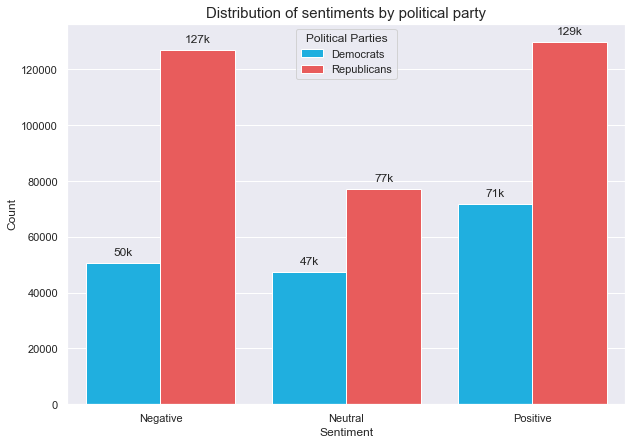

In [10]:
plt.figure(figsize=(10,7))
sns.set()
splot = sns.countplot(x="sentiment", data=data, hue='subject',palette=['#00BFFF','#FF4545'])

for p in splot.patches:
    splot.annotate(str(format(p.get_height(), '.0f'))[:-3]+'k', (p.get_x() + p.get_width() / 2., p.get_height() + 2000), ha = 'center', va= 'bottom', xytext = (0, 0), textcoords = 'offset points')

locs, _ = plt.xticks()
plt.xticks(ticks=locs,labels=['Negative','Neutral','Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of sentiments by political party',fontsize=15)
plt.legend(title='Political Parties')
plt.show()

Despite being imbalanced towards the republican party in number of tweets and since we will use the sentiment of the tweets to predict the results, we are not balancing the dataset as we will use sentiments (either negative or positive) to predict the elections results.

## Hashtags Preprocessing

In [11]:
# mentions contains id, user and mentioned_user names
hashtags = pd.read_csv('./datasets/Output_v3_hash.csv', quotechar='"', names = ['id','user','hashtags']
                       ,low_memory=False, skiprows=1)

In [12]:
# Combining hashtags with our predicted sentiment 
hashtags = data[['id','subject','sentiment','state']].merge(hashtags,on='id')[['subject','sentiment','hashtags','state']]

# Add variable to count number of tweets (Used in Tableau)
hashtags['counter'] = 1

In [13]:
# Compute total sentiment for each hashtag
hashtags = hashtags.groupby(['subject','hashtags','state']).aggregate({'sentiment': 'sum','counter':'sum'}).reset_index()

In [14]:
# Save datasets to csv file
hashtags.to_csv('./datasets/hashtags.csv')